# Anime Recommender Machine Learning Models

## Imported Libraries

#### Common Data Science Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### Surprise Libary (for SVD and KNN models)

In [2]:
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import SVD
# from surprise import accuracy
from surprise import Reader
from surprise import Dataset

#### User-Defined Libraries

In [3]:
import projutils

## Data Preprocessing

#### Main Anime Dataset (anime.csv)

In [4]:
anime_df = pd.read_csv("data/anime.csv")


print(anime_df.shape)
print(anime_df.columns.unique())
anime_df.head()

(17562, 35)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170,182126,131625,62330,20688,8904,3184,1357,741,1580
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,1-Sep-01,Unknown,...,30043,49201,49505,22632,5805,1877,577,221,109,379
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229,75651,86142,49432,15376,5838,1965,664,316,533
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182,4806,10128,11618,5709,2920,1083,353,164,131
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312,529,1242,1713,1068,634,265,83,50,27


#### Anime Ratings Dataset (rating_complete.csv)

In [5]:
ratings_df = pd.read_csv("data/frontend_ratings_sample.csv")

print(ratings_df.shape)
print(ratings_df.columns.unique())
ratings_df.head()

(203504, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,71,164,10
1,816,431,9
2,816,16870,7
3,816,199,8
4,816,164,9


#### Dataset Cleaning

In [6]:
print("Before:")
print(anime_df.shape)
print(ratings_df.shape)

anime_df.dropna(inplace=True)
ratings_df.dropna(inplace=True)

print("\nAfter:")
print(anime_df.shape)
print(ratings_df.shape)

Before:
(17562, 35)
(203504, 3)

After:
(17562, 35)
(203504, 3)


#### CSV for mapping Name to ID used by app.py (id_to_name.csv)

In [7]:
name_to_id_df = anime_df[['MAL_ID', 'Name', 'English name']]
name_to_id_df.to_csv('data/id_to_name.csv', index=False)

#### Dictionaries for Anime ID and Name Mappings

In [8]:
rid_to_name, name_to_rid = projutils.read_item_names()

## Data Exploratory Analysis

In [9]:
anime_ratings_counts = ratings_df['anime_id'].value_counts()
print(f'Number of rated anime: {len(anime_ratings_counts)}')
print(f'Total number of anime: {len(anime_df)}')
print(f'Percentage of rated anime: {(len(anime_ratings_counts) / len(anime_df) * 100):.2f}%')

Number of rated anime: 9646
Total number of anime: 17562
Percentage of rated anime: 54.93%


Rating Counts:


rating
8     50267
7     48783
9     33862
6     25155
10    24974
5     11680
4      4625
3      2162
2      1178
1       818
Name: count, dtype: int64

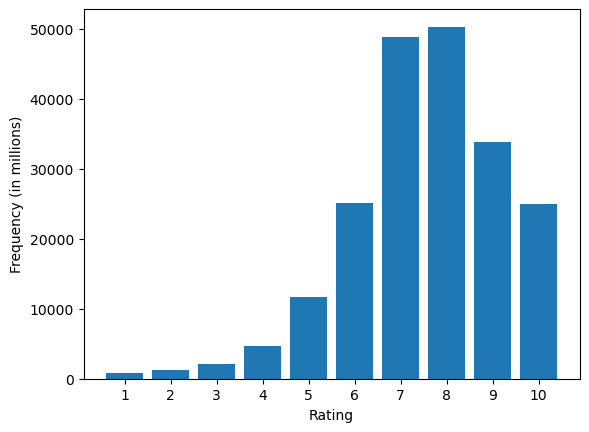

In [10]:
rating_values = ratings_df['rating'].unique()
rating_counts = ratings_df['rating'].value_counts()
plt.bar(rating_counts.index, rating_counts)
plt.xlabel("Rating")
plt.xticks(rating_values)
plt.ylabel("Frequency (in millions)")

print("Rating Counts:")
rating_counts

In [11]:
# returns bounds to be considered outlier for a distribution based on IQR method
def iqr_bounds(value_counts):
    quartiles = np.percentile(value_counts, [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower = quartiles[0] - 1.5 * iqr
    upper = quartiles[2] + 1.5 * iqr
    return lower, upper

# plots both a histogram and boxplot for user ratings per anime and user in a 4x4 grid
# contains an outliers parameter to keep/remove outliers from the distribution
def plot_distributions(df, outliers):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.tight_layout(pad=5)

    x_labels = ["Ratings Count Per Anime", "Ratings Count Per User"]

    for idx, column in enumerate(['anime_id', 'user_id']):
        value_counts = df[column].value_counts()
        lower, upper = iqr_bounds(value_counts)

        if not outliers:
            value_counts = value_counts[(value_counts >= lower) & (value_counts <= upper)]

        axs[0, idx].hist(value_counts, bins=50, edgecolor = "black")
        axs[0, idx].set_xlabel(x_labels[idx])
        axs[0, idx].set_ylabel("Frequency")

        axs[1, idx].boxplot(value_counts, vert=False)
        axs[1, idx].set_xlabel(x_labels[idx])
        axs[1, idx].set_yticks([])

#### Ratings Distributions with Outliers

In [12]:
population_counts_stats = pd.concat([ratings_df['anime_id'].value_counts().describe(),
                                     ratings_df['user_id'].value_counts().describe()],
                                     axis=1)
population_counts_stats.columns = ['Rating Count/Anime', 'Rating Count/User']
population_counts_stats

,Rating Count/Anime,Rating Count/User
count,9646.000000,1014.000000
mean,21.097242,200.694280
std,45.457356,270.298532
min,1.000000,1.000000
25%,2.000000,44.000000
50%,4.000000,124.000000
75%,19.000000,249.750000
max,610.000000,3315.000000


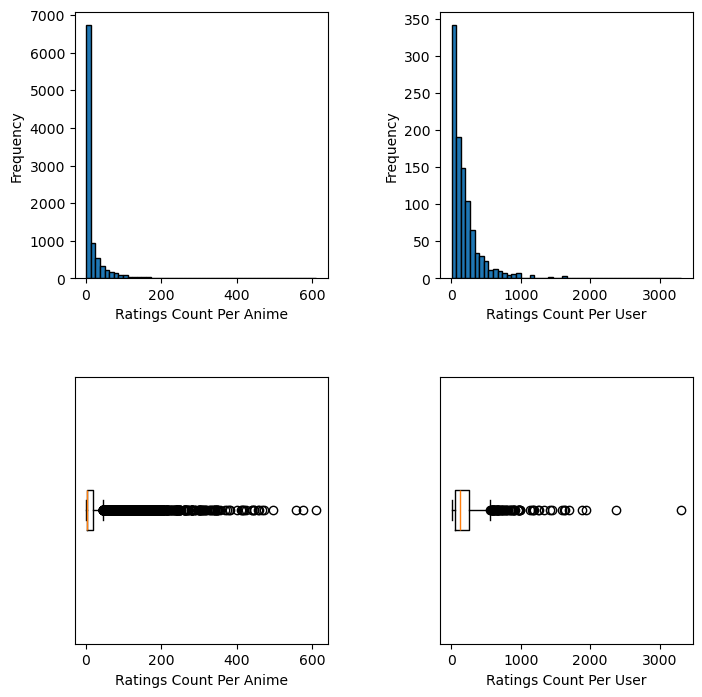

In [13]:
plot_distributions(ratings_df, outliers=True)

#### Ratings Distributions without Outliers

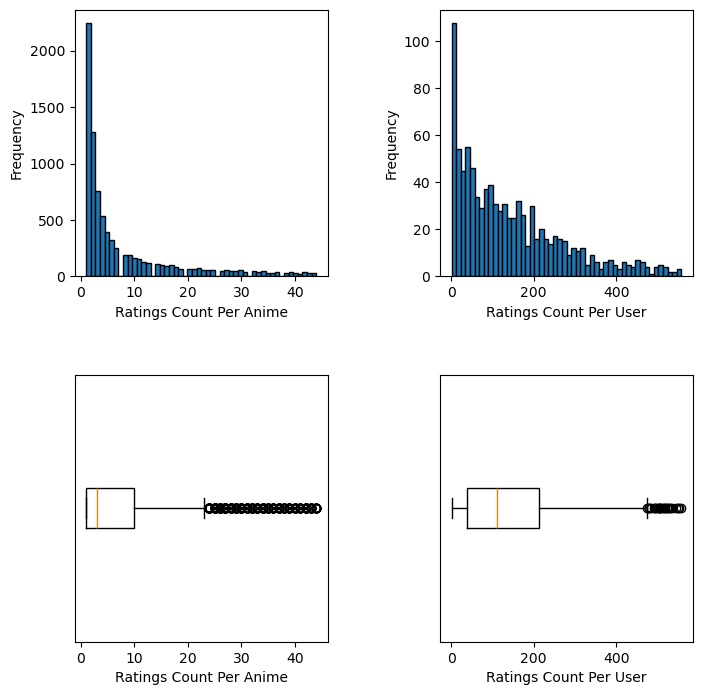

In [14]:
plot_distributions(ratings_df, outliers=False)

#### Ratings Random Sample

In [15]:
# From a dataframe sample all the ratings from N random users, using 'User ID'
def sample_n_user_ratings(source_df, n):
    users = source_df['user_id'].unique()
    user_id_set = set(np.random.choice(users, size=n, replace=True))

    result_df = source_df[source_df['user_id'].isin(user_id_set)].copy()
    
    return result_df

ratings_sample = sample_n_user_ratings(ratings_df, 2000)

In [16]:
sample_counts_stats = pd.concat([ratings_sample['anime_id'].value_counts().describe(),
                                 ratings_sample['user_id'].value_counts().describe()],
                                 axis=1)
sample_counts_stats.columns = ['Rating Count/Anime', 'Rating Count/User']
sample_counts_stats

,Rating Count/Anime,Rating Count/User
count,9487.000000,882.000000
mean,18.855170,202.810658
std,39.944341,276.313036
min,1.000000,1.000000
25%,2.000000,45.000000
50%,4.000000,125.500000
75%,17.000000,253.750000
max,530.000000,3315.000000


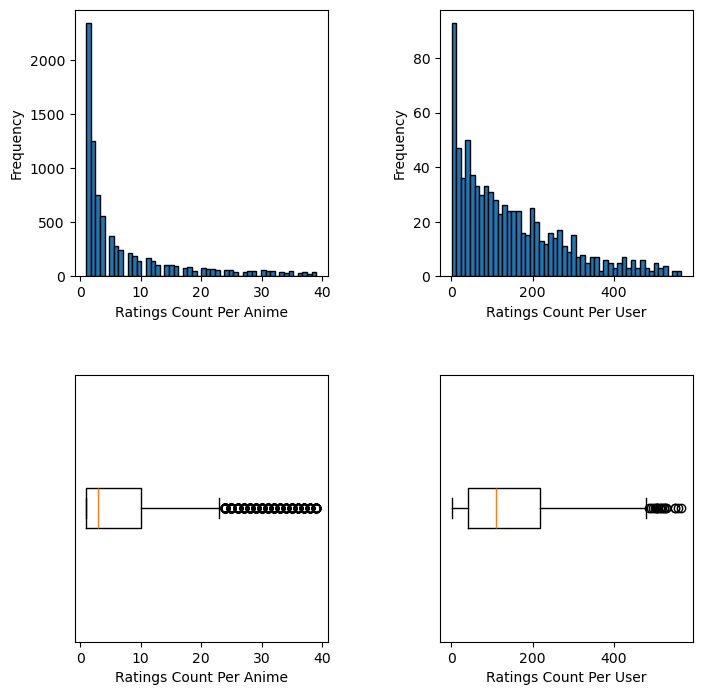

In [17]:
plot_distributions(ratings_sample, outliers=False)

unique anime rated over number of users sampled

/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


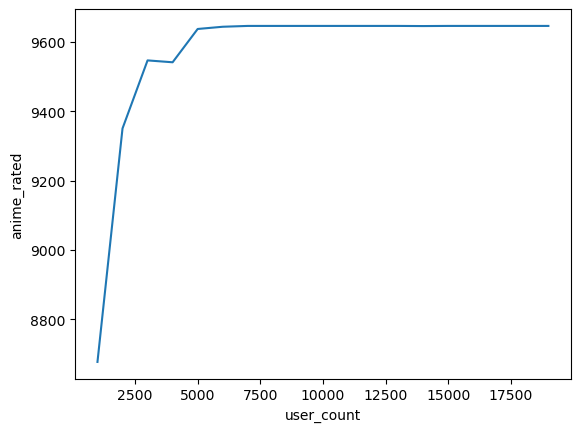

In [18]:
unique_anime_rated = pd.DataFrame(columns = ['user_count', 'anime_rated'])

for i in range(1000, 20000, 1000):
    count = 0
    for j in range(1,6):
        plot_sample = sample_n_user_ratings(ratings_df, i)
        animeRated = len(plot_sample['anime_id'].unique())
        count += animeRated
    count /= 5

    unique_anime_rated.loc[len(unique_anime_rated)] = [i, count]
    
sns.lineplot(x='user_count', y='anime_rated', data=unique_anime_rated, markers='o')
plt.show()

#### Ratings Sample CSV File (frontend_ratings_sample.csv)

In [19]:
# Save as file for frontend usage
ratings_sample.to_csv('data/frontend_ratings_sample.csv', index=False)

## Singular Value Decomposition (SVD)

Data Setup

In [20]:
svd_ratings_dataset = projutils.create_dataset_from_df(ratings_sample)

Grid Search

In [21]:
# Grid search for optimal hyperparameters
param_grid = {
    'lr_all' : [.01],
    'n_factors' : [10, 25, 50, 75, 100],
    'reg_all': [.1],
    'n_epochs' : [25, 50, 100]
}
gridsearch_svd = GridSearchCV(
    SVD, 
    param_grid = param_grid, 
    n_jobs = -1, 
    joblib_verbose = 3)

gridsearch_svd.fit(svd_ratings_dataset)

print(gridsearch_svd.best_score)
print(gridsearch_svd.best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


{'rmse': 1.2173571730173651, 'mae': 0.9122265754145552}
{'rmse': {'lr_all': 0.01, 'n_factors': 100, 'reg_all': 0.1, 'n_epochs': 25}, 'mae': {'lr_all': 0.01, 'n_factors': 100, 'reg_all': 0.1, 'n_epochs': 25}}


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   28.5s finished


/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 l

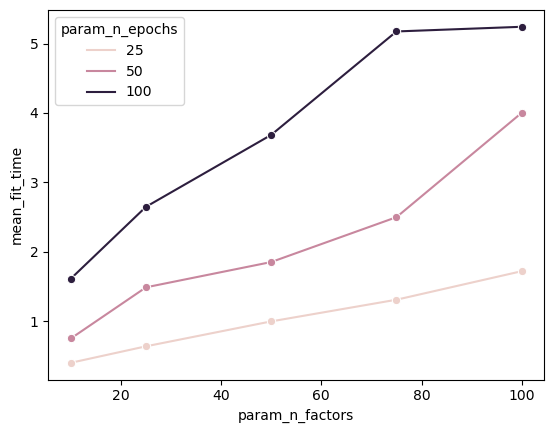

/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 l

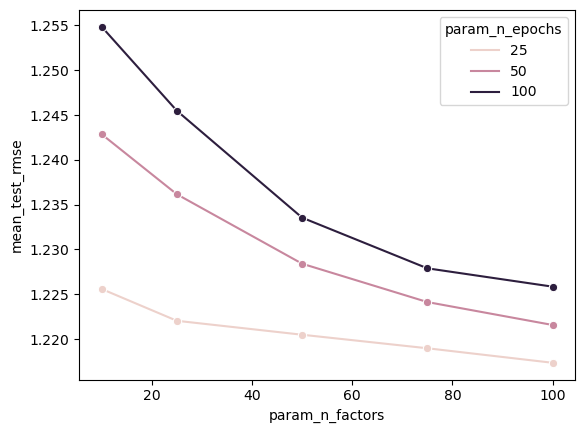

In [22]:
gs_results_df = pd.DataFrame.from_dict(gridsearch_svd.cv_results)

# Write results to file
gs_results_df.to_csv('data/svd_gridsearch_results.csv', index=False)

# Train time for different n factors (embedding size)
sns.lineplot(x='param_n_factors', y='mean_fit_time', hue='param_n_epochs', data=gs_results_df, marker='o')
plt.show()

# RMSE for different n factors
sns.lineplot(x='param_n_factors', y='mean_test_rmse', hue='param_n_epochs', data=gs_results_df, marker='o')
plt.show()

In [23]:
# Create model instance from grid search optimal hyperparameters
svd_instance = gridsearch_svd.best_estimator["rmse"]
# Print Params
print(svd_instance.__dict__)

{'n_factors': 100, 'n_epochs': 25, 'biased': True, 'init_mean': 0, 'init_std_dev': 0.1, 'lr_bu': 0.01, 'lr_bi': 0.01, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_bu': 0.1, 'reg_bi': 0.1, 'reg_pu': 0.1, 'reg_qi': 0.1, 'random_state': None, 'verbose': False, 'bsl_options': {}, 'sim_options': {'user_based': True}}


#### Recommendations with SVD Model

In [24]:
# Create predictions for a mew user provided their anime ratings
# This refits the entire model with the new user appended onto the base df with a user ID of -1

def create_predictions_for_user(model_instance, base_train_df, anime_ids, ratings):

    # Create suprise dataset with new user
    predict_dataset = projutils.create_predict_dataset(
        base_train_df, 
        anime_ids,
        ratings)

    # Retrain
    model_instance.fit(predict_dataset.build_full_trainset())

    # Generate predictions
    print("Generating Anime IDs")
    predict_anime_ids = list(rid_to_name)

    # Remove user provided ids from being predicted
    predict_anime_ids = [int(id) for id in predict_anime_ids if int(id) not in anime_ids]
    predict_anime_ids = pd.unique(predict_anime_ids)

    print("Getting Predictions")
    # Generate and return predictions for all the anime
    return projutils.get_predictions(model_instance, -1, predict_anime_ids)

def create_predictions_for_new_user(model_instance, base_train_df, anime_ids, ratings, print_top_25 = True):
# No randomness between each fit
    model_instance.random_state = 1

    user_1_predictions = create_predictions_for_user(
        model_instance,
        base_train_df,
        anime_ids,
        ratings
        )

    # Print predictions
    if print_top_25:
        print(projutils.get_top_n_string(user_1_predictions, 25, rid_to_name))

In [25]:
# User 1 
# Drama / romance
user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

create_predictions_for_new_user(svd_instance, ratings_sample, user_1_anime_ids, user_1_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. Kawaki wo Ameku (39112) - 8.2596
2. GintamaÂ° (28977) - 8.1598
3. Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare (15335) - 8.0808
4. Violet Evergarden Movie (37987) - 8.0165
5. Gotcha! (42984) - 7.9907
6. Oniisama e... (795) - 7.9883
7. Saiki Kusuo no Î¨-nan 2 (34612) - 7.9872
8. 3-gatsu no Lion 2nd Season (35180) - 7.9734
9. Gintama. (34096) - 7.9667
10. Owarimonogatari 2nd Season (35247) - 7.9412
11. Zoku Owarimonogatari (36999) - 7.9411
12. Violet Evergarden (33352) - 7.9344
13. Ginga Eiyuu Densetsu (820) - 7.9332
14. Ashita no Joe 2 (2921) - 7.9203
15. Hellsing Ultimate (777) - 7.907
16. Kizumonogatari III: Reiketsu-hen (31758) - 7.9058
17. Fullmetal Alchemist: Brotherhood (5114) - 7.9055
18. Gintama (918) - 7.8931
19. Code Geass: Hangyaku no Lelouch (1575) - 7.8922
20. Gintama' (9969) - 7.8824
21. Gintama': Enchousen (15417) - 7.8819
22. Kono Sekai no Katasumi ni (15227) - 7.8539
23. Beck (57) - 7.8524
24. 

/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


In [26]:
# User 2 
# Action / Adventure
user_2_anime_ids = [114, 31964, 32051, 34134, 38000]
user_2_ratings = [9, 10, 8, 9, 9]

create_predictions_for_new_user(svd_instance, ratings_sample, user_2_anime_ids, user_2_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. Kawaki wo Ameku (39112) - 9.302
2. Fullmetal Alchemist: Brotherhood (5114) - 9.2997
3. Ginga Eiyuu Densetsu (820) - 9.1173
4. 3-gatsu no Lion 2nd Season (35180) - 9.1147
5. Hunter x Hunter (2011) (11061) - 9.1073
6. Monster (19) - 9.0888
7. GintamaÂ° (28977) - 9.0516
8. Violet Evergarden Movie (37987) - 9.0475
9. Ashita no Joe 2 (2921) - 9.0444
10. Gintama (918) - 9.0319
11. Gintama' (9969) - 9.0246
12. Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare (15335) - 9.0171
13. Owarimonogatari 2nd Season (35247) - 8.9733
14. Gintama': Enchousen (15417) - 8.9711
15. Uchuu Kyoudai (12431) - 8.9565
16. Ping Pong the Animation (22135) - 8.9219
17. Mobile Suit Gundam: The Origin - Advent of the Red Comet (39592) - 8.9191
18. Oniisama e... (795) - 8.9159
19. Zoku Owarimonogatari (36999) - 8.9117
20. Code Geass: Hangyaku no Lelouch R2 (2904) - 8.9018
21. Gintama. (34096) - 8.8845
22. Gintama.: Shirogane no Tamashii-hen - Kouha

/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


In [27]:
# User 3 
# Boys Love
user_3_anime_ids = [114, 31964, 32051, 34134, 38000, 39533, 30346, 44055, 918]
user_3_ratings = [4, 5, 4, 6, 4, 10, 10, 9, 4]

create_predictions_for_new_user(svd_instance, ratings_sample, user_3_anime_ids, user_3_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. Kawaki wo Ameku (39112) - 8.2015
2. Violet Evergarden (33352) - 8.1214
3. Hunter x Hunter (2011) (11061) - 8.0652
4. Violet Evergarden Movie (37987) - 8.031
5. Monster (19) - 7.939
6. Koe no Katachi (28851) - 7.9244
7. Detective Conan Movie 20: The Darkest Nightmare (32005) - 7.9023
8. Mobile Suit Gundam: The Origin - Advent of the Red Comet (39592) - 7.8966
9. Fullmetal Alchemist: Brotherhood (5114) - 7.8894
10. Oniisama e... (795) - 7.8853
11. Gotcha! (42984) - 7.8577
12. City Hunter 2 (1471) - 7.8577
13. Mahou Shoujo MadokaâMagica (9756) - 7.8491
14. Sakasama no Patema (12477) - 7.8482
15. Urusei Yatsura (1293) - 7.8353
16. One Punch Man (30276) - 7.8217
17. Diamond no Ace: Act II (38731) - 7.8182
18. Kuroko no Basket Movie 4: Last Game (31658) - 7.8096
19. Kuroko no Basket 3rd Season (24415) - 7.79
20. Ashita no Joe 2 (2921) - 7.7842
21. ReLIFE: Kanketsu-hen (35466) - 7.7705
22. Kuroko no Basket 2nd Season (16894

/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


#### Training/Predict Time With Scaling User Count

Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)


Generating Anime IDs
Getting Predictions


/var/folders/lt/f4kb97ds4gq_h8_gdm5b5b5w0000gn/T/ipykernel_39389/1580876593.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predict_anime_ids = pd.unique(predict_anime_ids)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


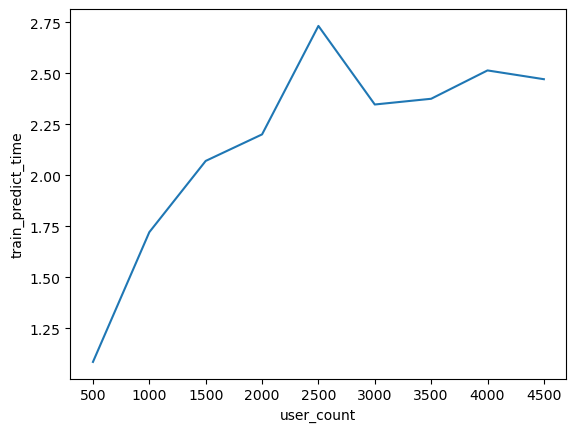

In [28]:
import time
user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

def plot_training_times(low, high, step, model_instance, anime_ids, ratings):
    train_times = pd.DataFrame(columns = ['user_count', 'train_predict_time'])

    for i in range(low, high, step):
        test_ratings_sample = sample_n_user_ratings(ratings_df, i)
        start = time.time()
        create_predictions_for_new_user(model_instance, test_ratings_sample, anime_ids, ratings, False)
        end = time.time()
        elapsed = end - start
        train_times.loc[len(train_times)] = [i, elapsed]
        # print(f'sample of {i} users took {elapsed} seconds to train and predict a new user')

    sns.lineplot(x='user_count', y='train_predict_time', data=train_times, markers='o')
    plt.show()

test_instance = SVD(lr_all = 0.01, n_factors = 100, reg_all = 0.1, n_epochs = 50)
plot_training_times(500, 5000, 500, test_instance, user_1_anime_ids, user_1_ratings)

## K-Nearest Neighbors (KNN)

#### Loading Sample into Dataset

In [29]:
reader = Reader(rating_scale=(1,10))
knn_data = Dataset.load_from_df(ratings_sample, reader)
knn_data

#### KNN Basic

In [30]:
knn_basic_algo = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_basic = cross_validate(knn_basic_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_basic

avg_rmse_basic = np.mean(cv_knn_basic['test_rmse'])
avg_mae_basic = np.mean(cv_knn_basic['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_basic, 4))
print("Average MAE:", round(avg_mae_basic, 4))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5337  1.5365  1.5464  1.5509  1.5352  1.5406  0.0068  
MAE (testset)     1.1764  1.1775  1.1822  1.1869  1.1770  1.1800  0.0040  
Fit time          0.17    0.18    0.18    0.17    0.17    0.17    0.00    
Test time         1.11    1.04    1.16    1.02    1.03    1.07    0.05    

Average RMSE: 1.5406
Average MAE: 1.18


#### KNN Baseline

In [31]:
knn_baseline_algo = KNNBaseline(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_baseline = cross_validate(knn_baseline_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_baseline

avg_rmse_baseline = np.mean(cv_knn_baseline['test_rmse'])
avg_mae_baseline = np.mean(cv_knn_baseline['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_baseline, 4))
print("Average MAE:", round(avg_mae_baseline, 4))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2790  1.2661  1.2648  1.2526  1.2672  1.2660  0.0084  
MAE (testset)     0.9583  0.9519  0.9495  0.9429  0.9543  0.9514  0.0051  
Fit time          0.30    0.35    0.33    0.35    0.32    0.33    0.02    
Test time         1.23    1.25    1.13    1.23    1.24    1.21    0.04    

Average RMSE: 1.266
Average

#### KNN With Means

In [32]:
knn_means_algo = KNNWithMeans(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_means = cross_validate(knn_means_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_means

avg_rmse_means = np.mean(cv_knn_means['test_rmse'])
avg_mae_means = np.mean(cv_knn_means['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_means, 4))
print("Average MAE:", round(avg_mae_means, 4))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3195  1.3092  1.3183  1.3104  1.3207  1.3156  0.0048  
MAE (testset)     0.9922  0.9890  0.9909  0.9887  0.9963  0.9914  0.0028  
Fit time          0.18    0.19    0.25    0.19    0.19    0.20    0.03    
Test time         1.06    1.16    1.13    1.24    1.15    1.15    0.06    

Average RMSE: 1.3156
Average MAE: 0.9914


#### Best KNN Model

In [33]:
best_knn_algo = None
best_knn_rmse = np.min([avg_rmse_basic, avg_rmse_baseline, avg_rmse_means])
best_knn_mae = np.min([avg_mae_basic, avg_mae_baseline, avg_mae_means])
best_algo_type = ""

if best_knn_rmse == avg_rmse_basic:
    best_algo_type = "KNN Basic"
    best_knn_algo = knn_basic_algo
elif best_knn_rmse == avg_rmse_baseline:
    best_algo_type = "KNN Baseline"
    best_knn_algo = knn_baseline_algo
else:
    best_algo_type = "KNN With Means"
    best_knn_algo = knn_means_algo

print("Best KNN Algorithm:", best_algo_type)
print("Best Average RMSE:", round(best_knn_rmse, 4))
print("Best Average MAE:", round(best_knn_mae, 4))

knn_rmses_df = pd.DataFrame({'KNN Basic': [avg_rmse_basic, avg_mae_basic],
                             'KNN Baseline': [avg_rmse_baseline, avg_mae_baseline],
                             'KNN With Means': [avg_rmse_means, avg_mae_means]})
knn_rmses_df.index = ['Average RMSE', 'Average MAE']
knn_rmses_df

Best KNN Algorithm: KNN Baseline
Best Average RMSE: 1.266
Best Average MAE: 0.9514


,KNN Basic,KNN Baseline,KNN With Means
Average RMSE,1.540557,1.265953,1.315616
Average MAE,1.179959,0.951377,0.991403


#### Recommendations with KNN

In [34]:
# model input is a single anime, output is k nearest animes
anime_name = "Cowboy Bebop"

# anime name must be mapped to id for model
anime_raw_id = int(name_to_rid[anime_name.lower()])
anime_inner_id = best_knn_algo.trainset.to_inner_iid(anime_raw_id)

anime_neighbors = best_knn_algo.get_neighbors(anime_inner_id, k=10)

# print recommendations
print("The 10 nearest neighbors of", anime_name, "are:")
for inner_id in anime_neighbors:
    print(rid_to_name[str(best_knn_algo.trainset.to_raw_iid(inner_id))])

The 10 nearest neighbors of Cowboy Bebop are:
Amon: Devilman Mokushiroku
Monster Musume no Iru Nichijou
WWW.Working!!
Golden Time
Idol Fantasy
B: The Beginning
Tales of Zestiria the Cross: Saiyaku no Jidai
Joker Game
Dansai Bunri no Crime Edge
"Gate: Jieitai Kanochi nite


## Exported Models for Front-end

In [35]:
import pickle

pickle.dump(best_knn_algo, open('models/knn_model.pkl','wb'))
pickle.dump(svd_instance, open('models/svd_model.pkl','wb'))